# Setup

Useful Links
- https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html
- https://archive.vn/20150408083711/http://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=DEC_10_SF1_G001&prodType=table
- https://www.kaggle.com/sudalairajkumar/covid19-in-usa

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

In [7]:
# Dictionary for state abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Functions for cleaning up data
def update_county_names(x):
    if 'US' in x:
        x = x[:-4]
    
    for a in us_state_abbrev.keys():
        if a in x:
            index = -1 * len(a)
            x = x[:index]
            x = x + us_state_abbrev[a]
    
    return x

def update_income(x):
    if type(x) == str:
        x = x.replace('$', '')
        x = x.replace(',', '')
    return int(x)

def update_num(x):
    x = x.replace(',', '')
    return int(x)

# Load COVID-19 Case Data
Download most recent data [here](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports).

In [11]:
raw = pd.read_csv('05-11-2020.csv')

# Drop unnecessary columns and remove all regions that are not US counties
raw = raw.drop(['FIPS', 'Last_Update', 'Long_'], axis=1)
raw.drop(raw[raw['Country_Region'] != 'US'].index, inplace=True)
raw.dropna(inplace=True)

# Rename columns
raw.rename(columns={'Lat':'Latitude', 'Combined_Key': 'County'},inplace=True)

# Clean up county names
raw['County'] = raw['County'].apply(update_county_names)

# Set 'County' as index
raw = raw.groupby('County').sum()

# Load population data
population = load_geo_data('PopulationEstimates.csv', ['FIPS', 'State', 'Area_Name'], {}, 'County')
raw = pd.concat([raw, population['POP_ESTIMATE_2018']], axis=1)
raw.dropna(inplace=True)
raw.rename(columns={'POP_ESTIMATE_2018':'Population'},inplace=True)
raw['Population'] = raw['Population'].apply(update_num)

# Filter out counties with less than min_sample_size
min_sample_size = 5000
raw = raw[raw['Confirmed'] >= min_sample_size]

raw

,Latitude,Confirmed,Deaths,Recovered,Active,Population
"Bergen, NJ",40.960109,17028.0,1358.0,0.0,15670.0,936692
"Broward, FL",26.151847,5882.0,258.0,0.0,5624.0,1951260
"Cook, IL",41.841448,53381.0,2361.0,0.0,51020.0,5180493
"Dallas, TX",32.766706,6123.0,145.0,0.0,5978.0,2637772
"District of Columbia, DC",38.904178,6389.0,328.0,0.0,6061.0,702455
"Essex, MA",42.668763,11432.0,669.0,0.0,10763.0,790638
"Essex, NJ",40.786813,15727.0,1431.0,0.0,14296.0,799767
"Fairfax, VA",38.836776,6200.0,243.0,0.0,5957.0,1150795
"Fairfield, CT",41.268099,13312.0,1034.0,0.0,12278.0,943823
"Harris, TX",29.860000,8176.0,179.0,0.0,7997.0,4698619


# Load geographical data

In [12]:
def load_geo_data(file, dropCols, dropRows, indexCol):
    df = pd.read_csv(file)
    for d in dropRows.keys():
        df.drop(df[df[d] != dropRows[d]].index, inplace=True)
    df.drop(dropCols, axis=1, inplace=True)
    df.dropna(inplace=True)
    df[indexCol] = df[indexCol].apply(lambda x: x.replace(' County', ''))
    df.set_index(indexCol, drop=True, inplace=True)
    
    return df

# Load temperature data
temp = load_geo_data('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011).csv', 
                     ['County Code', 'Avg Daily Max Air Temperature (C)', 'Avg Daily Min Air Temperature (C)'], {}, 'County')
temp

# Load heat index data
# Heat index = "how hot it really feels when relative humidity is factored in with the actual air temperature"
heat_index = load_geo_data('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011)-2.csv',
                           ['County Code'], {}, 'County')
heat_index = heat_index[heat_index['Avg Max Heat Index (C)'] != 'Missing']
heat_index['Avg Max Heat Index (C)'] = heat_index['Avg Max Heat Index (C)'].apply(lambda x: float(x))
heat_index

# Load unemployment data
unemploy = load_geo_data('Unemployment.csv', ['FIPS', 'State', 'Rural_urban_continuum_code_2013', 'Urban_influence_code_2013',
       'Metro_2013', ' Civilian_labor_force_2007 ', ' Employed_2007 ',
       ' Unemployed_2007 ', 'Unemployment_rate_2007',
       ' Civilian_labor_force_2008 ', ' Employed_2008 ', ' Unemployed_2008 ',
       'Unemployment_rate_2008', 'Civilian_labor_force_2009', 'Employed_2009',
       'Unemployed_2009', 'Unemployment_rate_2009',
       ' Civilian_labor_force_2010 ', ' Employed_2010 ', ' Unemployed_2010 ',
       'Unemployment_rate_2010', ' Civilian_labor_force_2011 ',
       ' Employed_2011 ', ' Unemployed_2011 ', 'Unemployment_rate_2011',
       ' Civilian_labor_force_2012 ', ' Employed_2012 ', ' Unemployed_2012 ',
       'Unemployment_rate_2012', ' Civilian_labor_force_2013 ',
       ' Employed_2013 ', ' Unemployed_2013 ', 'Unemployment_rate_2013',
       ' Civilian_labor_force_2014 ', ' Employed_2014 ', ' Unemployed_2014 ',
       'Unemployment_rate_2014', ' Civilian_labor_force_2015 ',
       ' Employed_2015 ', ' Unemployed_2015 ', 'Unemployment_rate_2015',
       ' Civilian_labor_force_2016 ', ' Employed_2016 ', ' Unemployed_2016 ',
       'Unemployment_rate_2016', 'Civilian_labor_force_2017', 'Employed_2017',
       'Unemployed_2017', 'Unemployment_rate_2017'], {},'Area_name')
unemploy

# Load poverty data
poverty = load_geo_data('PovertyRate.csv', ['Area_name', 'State', 'POVALL_2018', 'POP_ESTIMATE_2018'], {}, 'County')
poverty.rename({'Unnamed: 5': 'Poverty Rate'}, axis=1, inplace=True)
poverty

# Load presidential voting data
# Source: https://electionlab.mit.edu/data
pres_vote = load_geo_data('countypres_2000-2016.csv', ['state', 'state_po', 'county_short', 'FIPS', 'candidate',
                        'office', 'year', 'party'], {'party': 'democrat'}, 'County')
pres_vote

# Load pollution data
pollution = load_geo_data('annual_aqi_by_county_2019.csv', ['State', 'County (Short)', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10'], 
        {}, 'County')
pollution.rename(index=update_county_names, inplace=True)
pollution

# Load land area data
area = load_geo_data('LND01.csv', [], {}, 'County')
area.rename({'LND010200D': 'Land Area (mi^2)'}, axis=1, inplace=True)
area

# Load gender ratio data
gender = load_geo_data('SEX01.csv', [], {}, 'County')
gender.rename({'SEX350209D': 'Males per 100 Females'}, axis=1, inplace=True)
gender

,Males per 100 Females
County,
UNITED STATES,97.4
ALABAMA,94.0
"Autauga, AL",94.7
"Baldwin, AL",95.9
"Barbour, AL",113.6
...,...
"Sweetwater, WY",105.5
"Teton, WY",117.2
"Uinta, WY",106.0


# Calculate incidence and death rates

In [13]:
def cal_rate(rate, total, colName):
    df = pd.Series(dtype = float)
    
    # Calculating rate
    if (rate.index == total.index).all():
        df = rate/(total + rate)
    else:
        print('Whoops, looks like your counties dont match')
    
    # Drop countries that have a null rate (for death rate, don't have any cases)
    df.dropna(inplace=True)
    
    df = pd.DataFrame(df)
    df.rename(columns={df.columns[0]:colName},inplace=True)
    
    return df

# Get most recent numbers
total_confirmed = raw['Confirmed']
total_deaths = raw['Deaths']
total_pop = raw['Population']

# Calculate incidence rate
incidence_rate = cal_rate(total_confirmed, total_pop, 'Incidence Rate')
incidence_rate

# Calculate death rate
death_rate = cal_rate(total_deaths, total_confirmed, 'Death Rate')
death_rate

# # Calculate hospitalization rate
# hosp_rate = cal_rate()

,Death Rate
"Bergen, NJ",0.073861
"Broward, FL",0.042020
"Cook, IL",0.042356
"Dallas, TX",0.023133
"District of Columbia, DC",0.048831
"Essex, MA",0.055285
"Essex, NJ",0.083401
"Fairfax, VA",0.037715
"Fairfield, CT",0.072076
"Harris, TX",0.021424


# Merge data sets
Merge incidence/death rate with geographical data.

In [14]:
def merge_data1(covid_data, geo_data):
    df = geo_data.merge(covid_data, left_index=True, right_index=True)
    
    # Check missing counties
    print(f'We lost {covid_data.shape[0] - df.shape[0]} counties in our merge')
    
    return df
    

def merge_data2(covid_data, raw):
    df = pd.concat([raw, covid_data], axis=1)
    df = df.drop(['Confirmed', 'Deaths', 'Recovered', 'Active'], axis=1)
    return df

# Death rates and latitude
death_and_lat = merge_data2(death_rate, raw)
death_and_lat.describe()

inci_and_lat = merge_data2(incidence_rate, raw)

# Death rates and temperature
death_and_temp = merge_data1(death_rate, temp)
death_and_temp

inci_and_temp = merge_data1(incidence_rate, temp)

# Death rates and heat index
death_and_heatindex = merge_data1(death_rate, heat_index)
death_and_heatindex

inci_and_heatindex = merge_data1(incidence_rate, heat_index)

# Unemployment rate
unemploy1 = unemploy.drop(['Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Median_Household_Income_2018', 'Med_HH_Income_Percent_of_State_Total_2018'], axis=1)

death_and_unemploy = merge_data1(death_rate, unemploy1)
death_and_unemploy.rename(columns={'Unemployment_rate_2018':'Unemployment Rate'},inplace=True)
death_and_unemploy

inci_and_unemploy = merge_data1(incidence_rate, unemploy1)
inci_and_unemploy.rename(columns={'Unemployment_rate_2018':'Unemployment Rate'},inplace=True)
inci_and_unemploy
    
# Median income
unemploy2 = unemploy.drop(['Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018'], axis=1)

death_and_income = merge_data1(death_rate, unemploy2)
death_and_income.rename(columns={'Median_Household_Income_2018':'Median Household Income ($)'},inplace=True)
death_and_income['Median Household Income ($)'] = death_and_income['Median Household Income ($)'].apply(update_income)
death_and_income

inci_and_income = merge_data1(incidence_rate, unemploy2)
inci_and_income.rename(columns={'Median_Household_Income_2018':'Median Household Income ($)'},inplace=True)
inci_and_income['Median Household Income ($)'] = inci_and_income['Median Household Income ($)'].apply(update_income)
inci_and_income

# Death rates and income percent of state
unemploy3 = unemploy.drop(['Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Unemployment_rate_2018', 'Median_Household_Income_2018'], axis=1)
death_and_incomepercent = merge_data1(death_rate, unemploy3)
death_and_incomepercent.rename(columns={'Med_HH_Income_Percent_of_State_Total_2018':'Median HH Income Percent of State Total'},inplace=True)
death_and_incomepercent

# Poverty rate
death_and_povrate = merge_data1(death_rate, poverty)
death_and_povrate

inci_and_povrate = merge_data1(incidence_rate, poverty)
inci_and_povrate

# Death rates and urban influence codes
# https://www.ers.usda.gov/data-products/urban-influence-codes.aspx
population1 = population.drop(['Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013',
       'Urban_Influence_Code_2003', 'Economic_typology_2015', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018',
       'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018', 'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018',
       'NET_MIG_2018', 'RESIDUAL_2018', 'GQ_ESTIMATES_2018'], axis=1)
death_and_urbinfl = merge_data1(death_rate, population1)
death_and_urbinfl.rename(columns={'Urban_Influence_Code_2013': 'Urban Influence Code'},inplace=True)
death_and_urbinfl

# 2016 % Democrat presidential votes
pres_vote1 = pres_vote.drop(['candidatevotes', 'totalvotes', '% Democrat Votes (of major parties)'], axis=1)

death_and_demo = merge_data1(death_rate, pres_vote1)
death_and_demo.rename(columns={'% Democrat Votes': '% Democrat Votes in 2016 Elections'},inplace=True)
death_and_demo['% Democrat Votes in 2016 Elections'] = death_and_demo['% Democrat Votes in 2016 Elections'].apply(lambda x: float(x))
death_and_demo

inci_and_demo = merge_data1(incidence_rate, pres_vote1)
inci_and_demo.rename(columns={'% Democrat Votes': '% Democrat Votes in 2016 Elections'},inplace=True)
inci_and_demo['% Democrat Votes in 2016 Elections'] = inci_and_demo['% Democrat Votes in 2016 Elections'].apply(lambda x: float(x))
inci_and_demo

# Median AQI
death_and_aqi = merge_data1(death_rate, pollution)
death_and_aqi

inci_and_aqi = merge_data1(incidence_rate, pollution)
inci_and_aqi

# Population density
death_and_popden = merge_data1(death_rate, area)
death_and_popden = death_and_popden.join(total_pop)
death_and_popden['Population Density (/mi^2)'] = death_and_popden['Population'] / death_and_popden['Land Area (mi^2)']
death_and_popden

inci_and_popden = merge_data1(incidence_rate, area)
inci_and_popden = inci_and_popden.join(total_pop)
inci_and_popden['Population Density (/mi^2)'] = inci_and_popden['Population'] / inci_and_popden['Land Area (mi^2)']
inci_and_popden

# Gender ratio
death_and_gender = merge_data1(death_rate, gender)
death_and_gender

inci_and_gender = merge_data1(incidence_rate, gender)
inci_and_gender

We lost 1 counties in our merge
We lost 1 counties in our merge
We lost 1 counties in our merge
We lost 1 counties in our merge
We lost 2 counties in our merge
We lost 2 counties in our merge
We lost 2 counties in our merge
We lost 2 counties in our merge
We lost 2 counties in our merge
We lost -1 counties in our merge
We lost -1 counties in our merge
We lost 0 counties in our merge
We lost -1 counties in our merge
We lost -1 counties in our merge
We lost 0 counties in our merge
We lost 0 counties in our merge
We lost 0 counties in our merge
We lost 0 counties in our merge
We lost 0 counties in our merge
We lost 0 counties in our merge


,Males per 100 Females,Incidence Rate
"Bergen, NJ",95.2,0.017854
"Broward, FL",95.0,0.003005
"Cook, IL",94.8,0.010199
"Dallas, TX",103.1,0.002316
"Essex, MA",94.2,0.014253
"Essex, NJ",93.4,0.019285
"Fairfax, VA",98.6,0.005359
"Fairfax, VA",95.6,0.005359
"Fairfield, CT",96.1,0.013908
"Harris, TX",100.7,0.001737


# Plot linear regressions

In [15]:
def lin_regress(merged_data, col_death, col_data, start, line_length):
    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data[col_data], merged_data[col_death])
    predictions = np.linspace(start,line_length,5) * slope + intercept
    
    # Only plot if R^2 value > 0.05
    if (r_value*r_value) > 0.05:
        # Visualize using plt
        plt.scatter(merged_data[col_data], merged_data[col_death])
        plt.ylabel(col_death)
        plt.xlabel(col_data)
        plt.title(f'{col_death} vs {col_data}')
        plt.plot(np.linspace(start,line_length,5), predictions)
        plt.show()

        # Print important values
        print(f'p-values: {p_value}')
        print(f'R^2: {r_value*r_value}')
        print(f'Slope: {slope}')
    else:
        print(f'R^2: {r_value*r_value}')

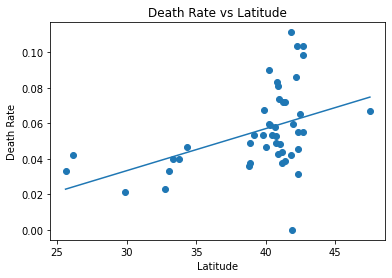

p-values: 0.0020116034637555377
R^2: 0.19685900206781026
Slope: 0.0023679388131192304


In [16]:
lin_regress(death_and_lat, 'Death Rate', 'Latitude', death_and_lat['Latitude'].min(), death_and_lat['Latitude'].max())

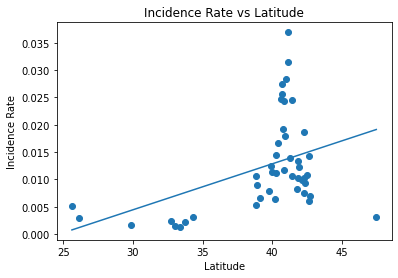

p-values: 0.0036101773950246337
R^2: 0.17689163914926284
Slope: 0.000839458272164502


In [17]:
lin_regress(inci_and_lat, 'Incidence Rate', 'Latitude', inci_and_lat['Latitude'].min(), inci_and_lat['Latitude'].max())

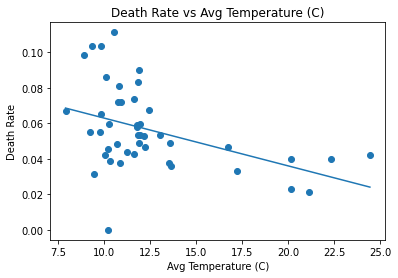

p-values: 0.0028376155376441713
R^2: 0.18906476116624038
Slope: -0.0026889918390021806


In [18]:
lin_regress(death_and_temp, 'Death Rate', 'Avg Temperature (C)', death_and_temp['Avg Temperature (C)'].min(), death_and_temp['Avg Temperature (C)'].max())

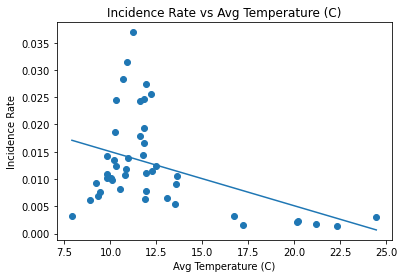

p-values: 0.0033141328014791647
R^2: 0.1836470021864478
Slope: -0.0009936610784007011


In [19]:
lin_regress(inci_and_temp, 'Incidence Rate', 'Avg Temperature (C)', inci_and_temp['Avg Temperature (C)'].min(), inci_and_temp['Avg Temperature (C)'].max())

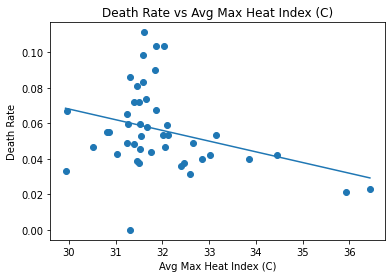

p-values: 0.029085324202755707
R^2: 0.10599158495027011
Slope: -0.006023908307622198


In [20]:
lin_regress(death_and_heatindex, 'Death Rate', 'Avg Max Heat Index (C)', death_and_heatindex['Avg Max Heat Index (C)'].min(), death_and_heatindex['Avg Max Heat Index (C)'].max())

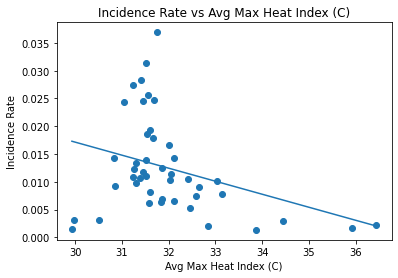

p-values: 0.023297015067484526
R^2: 0.11402347728501964
Slope: -0.0023426206556356557


In [21]:
lin_regress(inci_and_heatindex, 'Incidence Rate', 'Avg Max Heat Index (C)', inci_and_heatindex['Avg Max Heat Index (C)'].min(), inci_and_heatindex['Avg Max Heat Index (C)'].max())

In [22]:
lin_regress(death_and_unemploy, 'Death Rate', 'Unemployment Rate', death_and_unemploy['Unemployment Rate'].min(), death_and_unemploy['Unemployment Rate'].max())

R^2: 2.2242063064008146e-05


In [23]:
lin_regress(inci_and_unemploy, 'Incidence Rate', 'Unemployment Rate', inci_and_unemploy['Unemployment Rate'].min(), inci_and_unemploy['Unemployment Rate'].max())

R^2: 0.015871951920800924


In [24]:
lin_regress(death_and_income, 'Death Rate', 'Median Household Income ($)', death_and_income['Median Household Income ($)'].min(), death_and_income['Median Household Income ($)'].max())

R^2: 0.011226170728925143


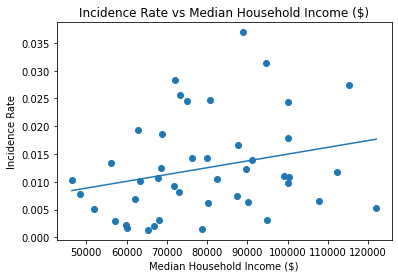

p-values: 0.09442663617755205
R^2: 0.06517315708771271
Slope: 1.2227562848161386e-07


In [25]:
lin_regress(inci_and_income, 'Incidence Rate', 'Median Household Income ($)', inci_and_income['Median Household Income ($)'].min(), inci_and_income['Median Household Income ($)'].max())

In [26]:
lin_regress(death_and_incomepercent, 'Death Rate', 'Median HH Income Percent of State Total', death_and_incomepercent['Median HH Income Percent of State Total'].min(), death_and_incomepercent['Median HH Income Percent of State Total'].max())

R^2: 0.0034513512570521323


In [27]:
death_and_povrate.drop(death_and_povrate[death_and_povrate['Poverty Rate'] > 30].index, inplace=True)
lin_regress(death_and_povrate, 'Death Rate', 'Poverty Rate', death_and_povrate['Poverty Rate'].min(), death_and_povrate['Poverty Rate'].max())

R^2: 0.0053286379376909065


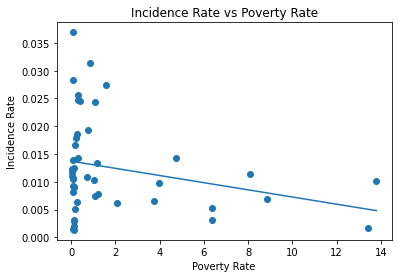

p-values: 0.08991201375796776
R^2: 0.06396760882676726
Slope: -0.0006452092393348637


In [28]:
inci_and_povrate.drop(inci_and_povrate[inci_and_povrate['Poverty Rate'] > 30].index, inplace=True)
lin_regress(inci_and_povrate, 'Incidence Rate', 'Poverty Rate', inci_and_povrate['Poverty Rate'].min(), inci_and_povrate['Poverty Rate'].max())

In [29]:
# lin_regress(death_and_urbinfl, 'Death Rate', 'Urban Influence Code', death_and_urbinfl['Urban Influence Code'].min(), death_and_urbinfl['Urban Influence Code'].max())

In [30]:
lin_regress(death_and_demo, 'Death Rate', '% Democrat Votes in 2016 Elections', death_and_demo['% Democrat Votes in 2016 Elections'].min(), death_and_demo['% Democrat Votes in 2016 Elections'].max())

R^2: 0.015356154460843057


In [31]:
lin_regress(inci_and_demo, 'Incidence Rate', '% Democrat Votes in 2016 Elections', inci_and_demo['% Democrat Votes in 2016 Elections'].min(), inci_and_demo['% Democrat Votes in 2016 Elections'].max())

R^2: 0.0012367373798467184


In [32]:
lin_regress(death_and_aqi, 'Death Rate', 'Median AQI', death_and_aqi['Median AQI'].min(), death_and_aqi['Median AQI'].max())

R^2: 0.048927493923899404


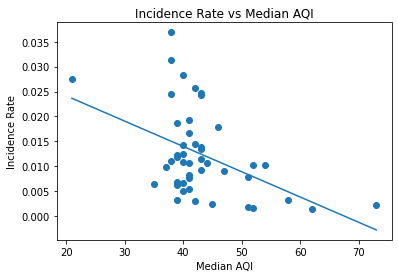

p-values: 0.0012272196797144495
R^2: 0.21347734517921033
Slope: -0.0005086384715699927


In [33]:
lin_regress(inci_and_aqi, 'Incidence Rate', 'Median AQI', inci_and_aqi['Median AQI'].min(), inci_and_aqi['Median AQI'].max())

In [34]:
lin_regress(death_and_popden, 'Death Rate', 'Population Density (/mi^2)', death_and_popden['Population Density (/mi^2)'].min(), death_and_popden['Population Density (/mi^2)'].max())

R^2: 0.013590248466852042


In [35]:
lin_regress(inci_and_popden, 'Incidence Rate', 'Population Density (/mi^2)', inci_and_popden['Population Density (/mi^2)'].min(), inci_and_popden['Population Density (/mi^2)'].max())

R^2: 0.00897973585161681


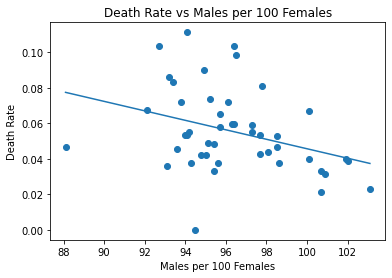

p-values: 0.019786892437179782
R^2: 0.11734264087467751
Slope: -0.002666982722521798


In [36]:
lin_regress(death_and_gender, 'Death Rate', 'Males per 100 Females', death_and_gender['Males per 100 Females'].min(), death_and_gender['Males per 100 Females'].max())

In [37]:
lin_regress(inci_and_gender, 'Incidence Rate', 'Males per 100 Females', inci_and_gender['Males per 100 Females'].min(), inci_and_gender['Males per 100 Females'].max())

R^2: 0.03554898643918853


# Create CSV file of important data

In [202]:
# Clean up data
unemploy1.rename(columns={'Unemployment_rate_2018':'Unemployment Rate'},inplace=True)

unemploy2.rename(columns={'Median_Household_Income_2018':'Median Household Income ($)'},inplace=True)
unemploy2['Median Household Income ($)'] = unemploy2['Median Household Income ($)'].apply(update_income)

popden = death_and_popden['Population Density (/mi^2)']

# Join data frames
result = raw
columns = [death_rate, incidence_rate, temp, heat_index, unemploy1, unemploy2, poverty, pollution, popden, gender]
for i in columns:
    result = result.join(i)

result.dropna(inplace=True)
print(result.columns)

# Reorder columns of large data frame
result = result[['Population', 'Confirmed', 'Active', 'Incidence Rate', 'Deaths', 'Death Rate', 'Latitude',
                'Avg Temperature (C)', 'Avg Max Heat Index (C)', 'Median Household Income ($)', 
                'Unemployment Rate', 'Poverty Rate', 'Median AQI', 'Population Density (/mi^2)',
                'Males per 100 Females']]

# Export large data frame to csv
result.to_csv('data_frame.csv', header=True)

result

Index(['Latitude', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population',
       'Death Rate', 'Incidence Rate', 'Avg Temperature (C)',
       'Avg Max Heat Index (C)', 'Unemployment Rate',
       'Median Household Income ($)', 'Poverty Rate', 'Median AQI',
       'Population Density (/mi^2)', 'Males per 100 Females'],
      dtype='object')


,Population,Confirmed,Active,Incidence Rate,Deaths,Death Rate,Latitude,Avg Temperature (C),Avg Max Heat Index (C),Median Household Income ($),Unemployment Rate,Poverty Rate,Median AQI,Population Density (/mi^2),Males per 100 Females
"Bergen, NJ",936692,17028.0,15670.0,0.017854,1358.0,0.073861,40.960109,11.610,31.66,100181.0,3.4,0.24,46,3795.348460,95.2
"Broward, FL",1951260,5882.0,5624.0,0.003005,258.0,0.042020,26.151847,24.445,34.45,57200.0,3.4,0.13,42,1478.641740,95.0
"Cook, IL",5180493,53381.0,51020.0,0.010199,2361.0,0.042356,41.841448,10.030,33.03,63347.0,4.0,13.79,54,3168.419733,94.8
"Dallas, TX",2637772,6123.0,5978.0,0.002316,145.0,0.023133,32.766706,20.165,36.44,59838.0,3.7,51.15,45,2903.244695,103.1
"Essex, MA",790638,11432.0,10763.0,0.014253,669.0,0.055285,42.668763,9.790,30.82,76373.0,3.4,4.75,40,954.265989,94.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Suffolk, NY",1481093,36911.0,35272.0,0.024315,1639.0,0.042516,40.883201,11.600,31.04,100075.0,3.9,1.10,43,624.125289,97.7
"Union, NJ",558067,14164.0,13289.0,0.024752,875.0,0.058182,40.658354,11.795,31.68,80737.0,4.3,0.31,43,5291.740944,95.7
"Wayne, MI",1753893,18194.0,16089.0,0.010267,2105.0,0.103700,42.280984,9.820,32.03,46440.0,5.2,1.02,52,2609.183279,92.7
"Westchester, NY",967612,31384.0,30157.0,0.031416,1227.0,0.037625,41.162784,10.890,31.51,94521.0,3.9,0.87,38,1934.914414,94.3


In [203]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
import numpy as np
from sklearn.model_selection import train_test_split

In [222]:
df = result
temp = df['Avg Temperature (C)']
pop_den = df['Population Density (/mi^2)']
heat = df['Avg Max Heat Index (C)']
income = df['Median Household Income ($)']
sex_ratio = df['Males per 100 Females']
air_quality = df['Median AQI']
incidence_rate = df['Incidence Rate']
death_rate = df['Death Rate']
X = np.array([temp, pop_den, income, sex_ratio, air_quality]).T
y1 = np.array(death_rate)
Y2 = np.array(incidence_rate)
xs = preprocessing.scale(X)
ys1 = preprocessing.scale(y1)
ys2 = preprocessing.scale(Y2)
reg1 = LinearRegression()
reg1 = reg1.fit(xs,ys1)
Y_pred = reg1.predict(xs)
rmse1 = np.sqrt(mean_squared_error(Y1, Y_pred))
r2_1 = reg1.score(X, ys1)

print(rmse)
print(r2_1)
print()

reg2 = LinearRegression()
reg2 = reg1.fit(xs,ys2)
Y_pred = reg2.predict(xs)
rmse2 = np.sqrt(mean_squared_error(Y2, Y_pred))
r2_2 = reg2.score(X, ys2)

print(rmse2)
print(r2_2)

0.6441648595385184
-4200214428.7535906

0.7164600361552859
-5920917368.033694


In [223]:
regr = LinearRegression()
regr.fit(xs, Y1)
X_constant = sm.add_constant(xs)
model1 = sm.OLS(ys1, X_constant).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                 2.012e+05
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        14:26:58   Log-Likelihood:            -1.1353e+06
No. Observations:             1048618   AIC:                         2.271e+06
Df Residuals:                 1048612   BIC:                         2.271e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e-13      0.001    2.7e-10      1.000      -0.001       0.001
x1            -0.3923      0.001   -465.523      0.000      -0.394      -0.391
x2            -0.0004      0.001     -0.505      0.613      -0.002       0.001
x3            -0.5307      0.001   -632.407      0.000      -0.532      -0.529
x4            -0.0019      0.001     -2.666      0.008      -0.003      -0.000
x5            -0.0688      0.001    -74.575      0.000      -0.071      -0.067
===============================================================================
Omnibus:                  3083197.794   Durbin-Watson:                    1.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   458023359637921.062
Skew:                         -38.789   Prob(JB):                          0.00
Kurtosis:                  102389.019   Cond. No.                          2.20
===============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
regr = LinearRegression()
regr.fit(xs, Y2)
X_constant = sm.add_constant(xs)
model2 = sm.OLS(ys2, X_constant)
lin_reg2 = model2.fit()
lin_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                 2.212e+05
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        14:27:01   Log-Likelihood:            -1.1103e+06
No. Observations:             1048618   AIC:                         2.221e+06
Df Residuals:                 1048612   BIC:                         2.221e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.278e-14      0.001   1.36e-10      1.000      -0.001       0.001
x1            -0.2514      0.001   -305.603      0.000      -0.253      -0.250
x2            -0.0005      0.001     -0.731      0.465      -0.002       0.001
x3            -0.6300      0.001   -768.821      0.000      -0.632      -0.628
x4             0.0003      0.001      0.404      0.686      -0.001       0.002
x5            -0.3471      0.001   -385.264      0.000      -0.349      -0.345
===============================================================================
Omnibus:                  4962711.255   Durbin-Watson:                    2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   334852121339290.500
Skew:                         177.235   Prob(JB):                          0.00
Kurtosis:                   87545.699   Cond. No.                          2.20
===============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
def train(X, Y, testsize):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1)
    return X_train, X_test, y_train, y_test

In [215]:
def regression(X, X_train, y_train):
    regress = LinearRegression()
    regress = regress.fit(X_train, y_train)
    y_pred = regress.predict(X_test)
    X_opt = X[:, range(0, X.shape[1])]
    regressor_ls = sm.OLS(endog = y, exog = X_opt).fit()
    return regressor_ls.summary()